In [1]:
import numpy as np
import pymisca.util as pyutil;reload(pyutil)
import pymisca.vis_util as pyvis;reload(pyvis)
%matplotlib inline 
plt = pyutil.plt
np = pyutil.np
pd = pyutil.pd

is in ipython: 1 


[WARN] pymisca.vis_util cannot find network
[IMPORT] cannot import "matplotlib_venn"
[WARN] pymisca.vis_util cannot find network
[IMPORT] cannot import "matplotlib_venn"


is in ipython: 1 


In [2]:
# import tensorflow_probability.python.distributions as tfdist

# import pymisca.tensorflow_extra as pytf
# ed = edm = pytf.ed
# tf = pytf.tf;

# import pymisca.util as pyutil
# np = pyutil.np

# from pymisca.models import BaseModel
# sess = tf.InteractiveSession()
# testi = 1

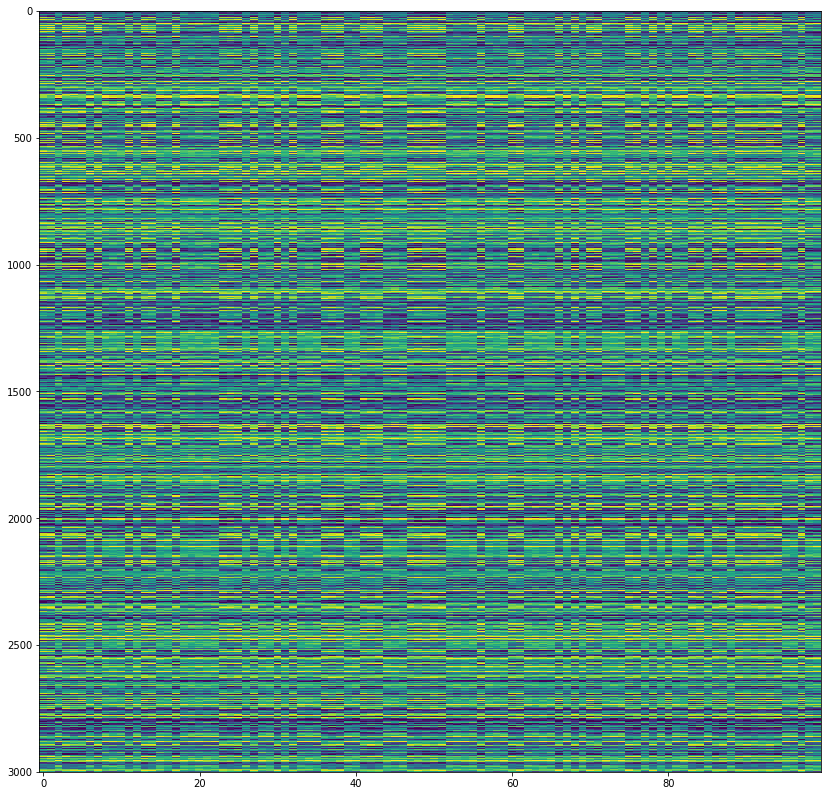

In [3]:
# X.shape
import pymisca.vis_util as pyvis
if 1:
    nx = 3000
    ny = 100
    ncatx,ncaty=20,2
    cat_x  = np.random.randint(ncatx,size=nx)[:,None]
    cat_y  = np.random.randint(ncaty,size=ny)[None]
    cat_x_bd,cat_y_bd = np.broadcast_arrays(cat_x,cat_y)
    lookup = np.random.random(size=(ncatx,ncaty))*5
    X_real = X =  lookup[cat_x_bd,cat_y_bd]
    X += np.random.random(size=X.shape)
    pyvis.heatmap(X) 


In [4]:
# 
ncatx = 9
ncaty = 11
alpha = 0.1


In [5]:
%%writefile /home/shouldsee/repos/pymisca/pymisca/tensorflow_extra_/matrix_decomp.py

import tensorflow_probability.python.distributions as tfdist
import pymisca.tensorflow_extra as pytf
ed = edm = pytf.ed
tf = pytf.tf;

import pymisca.util as pyutil
np = pyutil.np

from pymisca.models import BaseModel


bkd = tfdist
class matrixDecomp__VIMAP(BaseModel):
    bkd    = tfdist
    emDist = tfdist.Normal
    
    em_key =[
        'loc',
        'scale',
        ]
    mix_key = [
            'mix_x',
            'mix_y'
        ]
    
    def __init__(self,D=None,K=20,
                 debug=False,NCORE=1,alpha = None,
                 ncatx = 1,
                 ncaty = 1,
                 *args,**kwargs):
        super(
            matrixDecomp__VIMAP,
            self).__init__(*args,**kwargs)
        self.NCORE= NCORE
        self.K = K
        self.D = D
        self.initialised = False
        self.sess = None
        self.feed_dict = None
        self.debug = debug
        self.alpha = 0.1 if alpha is None else alpha
        self.ncatx = ncatx
        self.ncaty = ncaty
        if D is not None and not debug:
            self.init_model(D=D)  
            
#     def __init__(self,D=None,K = None,alpha = 1.0):
    def init_model(self,D=None,K = None,alpha = 1.0):
        if self.initialised:
            return self

#         self.D = D = self.D if D is None else D
#         assert D is not None
#         self.K = K = self.K if K is None else K
#         assert K is not None

        prior = self.make_prior()
        post = self.make_post()

        ##### Dictonary for constructing self.emDist(**self.param)
    #         self.

        self.param_key = (self.em_key + 
                          self.mix_key)

#         self.paramDict = {getattr(prior,name,None):
#                           getattr(post,name,None) 
#                           for name in self.param_key}

#         self.paramDict = {k:v 
#                           for k,v in self.paramDict.items() 
#                           if k is not None and v is not None}

        self.initialised = True; 
        return self
    
    def make_prior(self):
        self.alpha = 1.
        ncatx,ncaty = self.ncatx,self.ncaty
        if self.debug:
            print ('[making prior]')
        self.prior = prior = pyutil.util_obj()
        
        bkd = self.bkd
        
        prior.mix_x = bkd.Dirichlet(tf.ones(ncatx) * self.alpha)
        
        prior.mix_y = bkd.Dirichlet(tf.ones(ncaty) * self.alpha)
        

        shape=(ncatx,ncaty)
#         prior.loc = bkd.Normal(tf.zeros(shape),tf.ones(shape),)
        prior.locLR  = bkd.Logistic(0.,1.)
        prior.xcat = bkd.Normal(0.,1.)
#         prior.ycat = bkd.Dirichlet(tf.ones(ncaty,dtype='float32')/ncaty * self.alpha)
        
        prior.ycat = bkd.Beta(concentration0= self.alpha * 0.01,
                              concentration1= self.alpha * 0.01)

        prior.xbase = bkd.Normal(0.,1.)
        return prior

#         prior.loc = bkd.Normal(0.,1.,shape=(ncatx,ncaty))
        
#         prior
#         bkd.Dirichlet(self.alpha)
#         self.blk.
    def make_post(self):
        D = self.D
        K = self.K
        ncatx,ncaty = self.ncatx,self.ncaty
#         alpha = self.D/2.
    #     name = 'test'
        self.post = post = pyutil.util_obj()
        self.postScope = self.get_variable_scope('post')
        with self.postScope:

            post.mix_x = tf.square(tf.nn.l2_normalize( 
                tf.get_variable(shape=(ncatx,),name = 'mix_x',)
            ))
            post.mix_y = tf.square(tf.nn.l2_normalize( 
                tf.get_variable(shape=(ncaty,),name ='mix_y')
            ))
            
            post.locLR =  tf.get_variable(shape=(ncatx,ncaty),name='factor')
            post.loc = 2 * tf.nn.sigmoid(
               post.locLR
            ) - 1.
#             post.loc = tf.nn.l2_normalize(post.locLR,axis=0)

            post.mix_xy  = post.mix_x[:,None] * post.mix_y [None]
            post.weight = post.mix_xy_flat = tf.reshape(post.mix_xy,[-1])
            
#             scale = 0.5
            scale = tf.nn.softplus( tf.get_variable(shape=(1,),name='scale') 
                                       )
    
            post.scale = scale  * tf.ones(shape=(ncatx,ncaty))
#             post.loc = tf.get_variable(shape=)
        return post       

    def make_mixture(self,X=None,env=None):
    #     K = self.K
#         N = len(X)    
        shape = X.shape
#         env = self.get_env(env)
        env = post = self.post
        mixShape   = env.mix_xy.shape.as_list()
        env.components = components = np.ndarray(dtype='O',shape=mixShape)
        for x, y in np.ndindex(tuple(mixShape)):
            pdict = {k:env[k][x,y]
                                   for k in self.em_key}
            comp = self.emDist(**pdict)
            components[x,y] = comp

        
#         env.cat = self.bkd.Categorical(
#             probs = env.weight,
#     #             sample_shape=N
#         )

#         env.emission = self.bkd.Mixture(
#             cat = env.cat, 
#             components= np.ravel(env.components).tolist(),
#     #             sample_shape=N,
#         )        
        
        with self.get_variable_scope('training'):
#             post.xcat = tf.square(tf.nn.l2_normalize( 
#                 tf.get_variable(shape=(shape[0],self.ncatx),name ='mix_x'),
#                 axis=-1,
#             ))

            post.xcat = tf.nn.softplus((
                tf.get_variable(shape=(shape[0], self.ncatx),name ='mix_x')
#                 axis=-1,
            ))
            

            post.xbase =  tf.get_variable(shape=(shape[0],1),name = 'x_intercept')

            post.ycat = (tf.nn.sigmoid( 
                tf.get_variable(shape=(shape[1],self.ncaty),name ='mix_y')
#                 axis= -1,
            ))       
            
            
#             post.ycat = tf.square(tf.nn.l2_normalize( 
#                 tf.get_variable(shape=(shape[1],self.ncaty),name ='mix_y'),
#                 axis= -1,
#             ))
            post.locPer = reduce(tf.matmul, [post.xcat, post.loc, tf.transpose(post.ycat)])

            
#         post.xcat.T[None]
            mix_xy =  post.xcat[:,None,:,None] * post.ycat[None,:,None,:]
            mix_xy = tf.reshape(mix_xy,list(shape) + [-1])        
            post.mixPer = mix_xy
            
        env.cat = self.bkd.Categorical(
            probs = mix_xy,
#     #             sample_shape=N
        )
        
#         bkd.Mixture()
#         return 
#         print 'testing'
#         return 
#         loc = tf.matmul(
#             tf.matmul(post.xcat ,post.loc)
#         loc = .matmul(tf.transpose(post.ycat))
        xbase_init = X.mean(axis=1,keepdims=1)
        env.emission = self.bkd.Normal(post.locPer 
                                       + xbase_init
                                       + post.xbase * post.scale[0,0]/np.sqrt(shape[0]), 
                                       post.scale[0,0])

#         comp = np.ravel(env.components).tolist()
#         env.emission = self.bkd.Mixture(
#             cat = env.cat, 
# #             components_distribution= comp,
#             components= comp,
# #             sample_shape=shape,
#         )        
    
        return env.emission
    def get_variable_scope(self,ext, name=None):
        if name is None:
            name = self.name
        scope_name = name+'/%s'%ext
        try:
            tf.get_variable(scope_name,[1])
            reuse = None
        except:
            reuse = True
        print ('reuse',reuse)
        scope = tf.variable_scope(scope_name, reuse=reuse)
        return scope
    
    def get_env(self,env=None):
        if env is None:
            env = self.prior
        elif isinstance(env,str):
            env = getattr(self,env)
        return env
    
    def _fit(self,X, 
             n_iter = 1000, 
             n_print=100, 
             env=None,
             optimizer = None, 
             **kwargs):
        
        K = self.K
        N = len(X)
#         emission = self.build_likelihood(X,env=env)
        self.init_model()
    
        mdl, (last_vars, hist_loss, opt) = self._fit_MAP(
            X,
            MAX_ITER = n_iter,
            optimizer = optimizer,
            **kwargs)
        
        return hist_loss
        
#     _class = matrixDecomp__VIMAP





# _class.build_likelihood = make_mixture


    def _fit_MAP(self,x_obs, optimizer = None, **kwargs):
        self.init_model()
        mdl = self.make_mixture(X=x_obs,env='post')
        x_place = tf.placeholder(dtype='float32')

        ### prior likelihood
        self.lp_param = lp_param = [
            tf.reduce_sum(
                prv.log_prob(self.post[k])  ### ed.RandomVariable.value()
            ) 
            if prv.__class__.__name__ != 'Uniform' 
            else 0.
            for k,prv in self.prior.__dict__.items()]
    #         print (tf.reduce_sum(lp_param))
    
        ### data likelihood
        self.lp_data = lp_data = tf.reduce_sum(
            mdl.log_prob(x_place)
        )
        lp = tf.reduce_sum(
            map(tf.reduce_sum,[
                lp_param,
                lp_data])
        )
        loss = -lp
    #         loss = 0.
    #         loss += tf.reduce_sum(-lp_param) + tf.reduce_sum()

        self.feed_dict = {x_place:x_obs}
    #         fitted_vars_dict = {k:x.value() for k,x in 
    #                        self.post.__dict__.iteritems() 
    #                        if not isinstance(x,list) and k in self.param_key}
        self.sess = pytf.newSession(NCORE=self.NCORE)

#         tf.global_variables_initializer().run()
        
        sess, last_vars, hist_loss, opt = pytf.op_minimise(
            loss,
            self.freeVarDict('post').values(),
            optimizer = optimizer,
            feed_dict = self.feed_dict,
            sess = self.sess,
            **kwargs

        )
    #         self.sess = sess
        return mdl,(last_vars, hist_loss, opt)

    def freeVarDict(self, env):
        if isinstance(env,dict):
            idict = env
        else:
            if isinstance(env,str):
                env = getattr(self,env)
            else:
                raise Exception('"env" not recognised:%s'%env)
            idict = env.__dict__
        odict = {k:
#                  x.value() ### for edward.PointMass()
                 x
                 for k,x in 
                       idict.iteritems() 
                       if not isinstance(x,list) and k in self.param_key}            
        return odict

Overwriting /home/shouldsee/repos/pymisca/pymisca/tensorflow_extra_/matrix_decomp.py


In [6]:
# tfdist.Beta(concentration0=0.1,concentration1=0.1)

In [7]:
# tf.nn.sigmoid

In [8]:
# tf.nn.tanh

In [9]:
import pymisca.tensorflow_extra_.matrix_decomp as mym ;reload(mym)
#     _class._fit_MAP = _fit_MAP
_class = mym.matrixDecomp__VIMAP
testi = 0

/home/shouldsee/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[WARN]unable to import edward.models


In [10]:
testi += 1
ob = _class(D=2,ncatx = 10, ncaty = 4, debug=1,name= 'test_%s'%testi)
post = ob.make_post()

self= ob
# em = make_mixture(self,env='post')

# with sess.as_default():
#     tf.global_variables_initializer().run()

('reuse', None)


In [11]:
# pytf.op_minimise??

In [12]:
# imporpymisca.tensorflow_extraen
import tensorflow as tf
opt = tf.train.AdamOptimizer(0.1)
# opt = tf.train.AdadeltaOptimizer(1.)
# opt = None

# with sess.as_default():
    
hist_loss = ob.fit(X=X, n_print=10., optimizer=opt)
sess = ob.sess

[making prior]
('reuse', True)
('reuse', None)
Iter 0 476999.25
Iter 100 84350.84
Iter 200 81154.84
Iter 300 79522.91
Iter 400 78961.27
Iter 500 78567.99
Iter 600 78253.81
Iter 700 77985.266
Iter 800 77739.02
Iter 900 77501.64


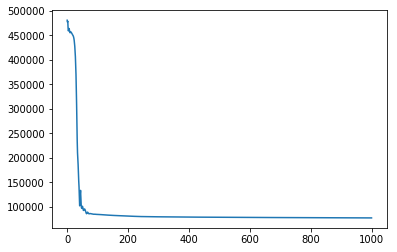

In [13]:
plt.plot(hist_loss)

In [14]:
with sess.as_default():
    em = ob.post.emission
    ys = em.sample().eval()
#     ys = ob.post.locPer.eval()
    loc = ob.post.loc.eval()
    wt = ob.post.weight.eval()
    print ob.post.scale[0,0].eval()    

0.28225228


In [15]:
ob.post.emission.sample().eval(session=sess)

array([[5.31137  , 5.8147783, 4.6949215, ..., 5.581287 , 4.480672 ,
        4.054735 ],
       [3.1910448, 3.3466487, 3.7227113, ..., 3.1486819, 3.618177 ,
        3.4805942],
       [3.9604783, 3.2971108, 2.752289 , ..., 3.1732721, 3.1698563,
        2.8217497],
       ...,
       [3.914195 , 4.988638 , 4.4752994, ..., 4.056601 , 4.474472 ,
        4.0377226],
       [2.8880837, 3.430027 , 1.6599278, ..., 3.3890796, 1.6022301,
        1.1446198],
       [0.6262989, 1.1375052, 4.3081765, ..., 1.3740659, 3.921002 ,
        4.2068686]], dtype=float32)

In [16]:
# ob.make_like
# ob
# em.event_shape

In [17]:
prior = pyutil.util_obj()



In [18]:
# prior.loc.log_prob(post.loc).eval(session=sess)

In [19]:
# ob.post.loc.__class__

In [20]:
# # type(post.emission)
# {k:type(v) 
#  for kmvob.post.__dict__.items()}

In [21]:
import tensorflow_probability.python.distributions as tfdist
def quick_eval(v):
    if isinstance(v,np.ndarray):
        res =  v
    elif isinstance(v,tfdist.Distribution):
        res = v
    else:
        res = v.eval()
    return res

In [22]:
# tf.e

In [23]:
with sess.as_default():
#     post = pyutil
    post = pyutil.util_obj(**{k:quick_eval(ob.post[k]) for k in ob.post.__dict__})
    

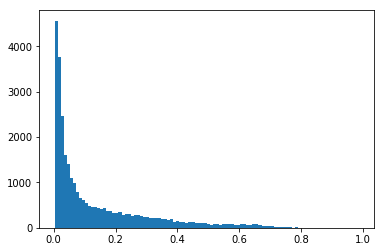

In [24]:
plt.hist(post.xcat.ravel(),100);

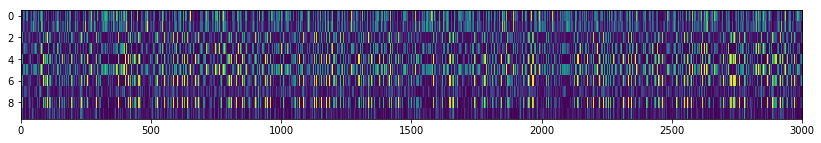

In [25]:
pyvis.heatmap(post.xcat.T )

In [26]:
post.xcat.sum(axis=1)

array([0.9821939 , 1.1223894 , 0.64685804, ..., 0.63827735, 1.5651977 ,
       2.2599084 ], dtype=float32)

In [27]:
post.scale

array([[0.28225228, 0.28225228, 0.28225228, 0.28225228],
       [0.28225228, 0.28225228, 0.28225228, 0.28225228],
       [0.28225228, 0.28225228, 0.28225228, 0.28225228],
       [0.28225228, 0.28225228, 0.28225228, 0.28225228],
       [0.28225228, 0.28225228, 0.28225228, 0.28225228],
       [0.28225228, 0.28225228, 0.28225228, 0.28225228],
       [0.28225228, 0.28225228, 0.28225228, 0.28225228],
       [0.28225228, 0.28225228, 0.28225228, 0.28225228],
       [0.28225228, 0.28225228, 0.28225228, 0.28225228],
       [0.28225228, 0.28225228, 0.28225228, 0.28225228]], dtype=float32)

/home/shouldsee/.local/lib/python2.7/site-packages/pymisca/vis_util.py:631: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  ys,edg = np.histogram(xs,bins,normed=normed)
/home/shouldsee/.local/lib/python2.7/site-packages/pymisca/vis_util.py:631: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  ys,edg = np.histogram(xs,bins,normed=normed)


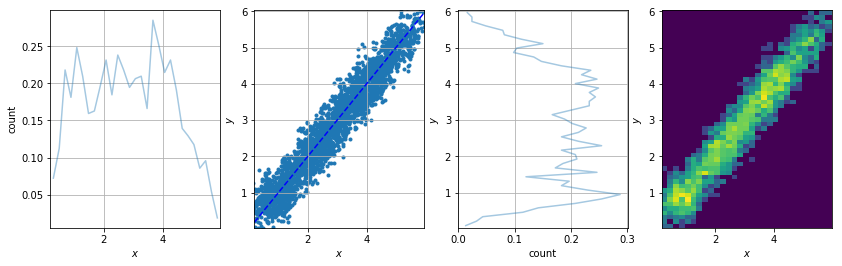

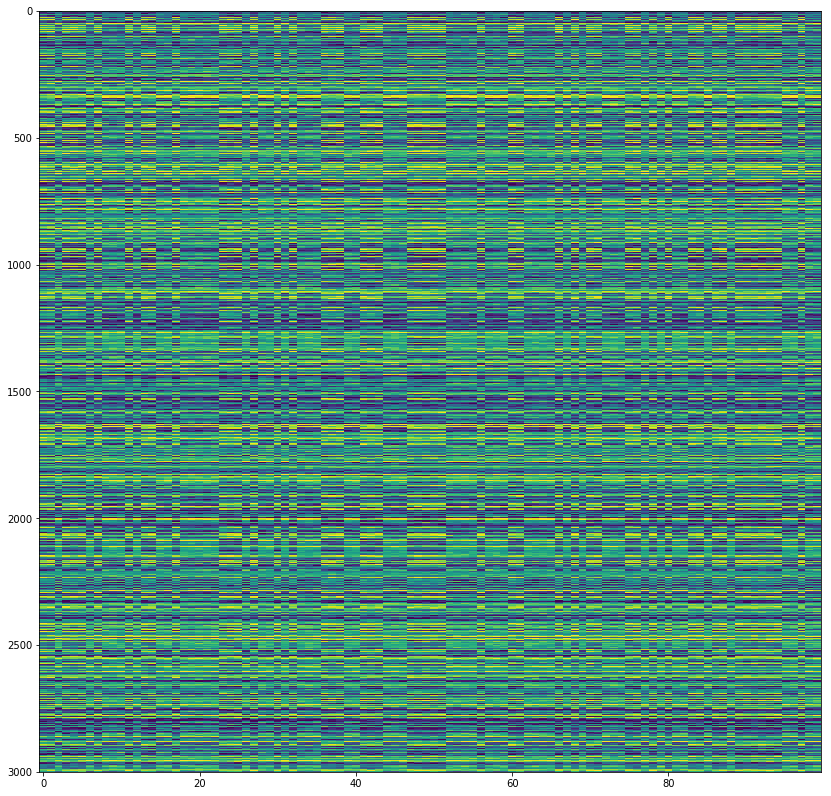

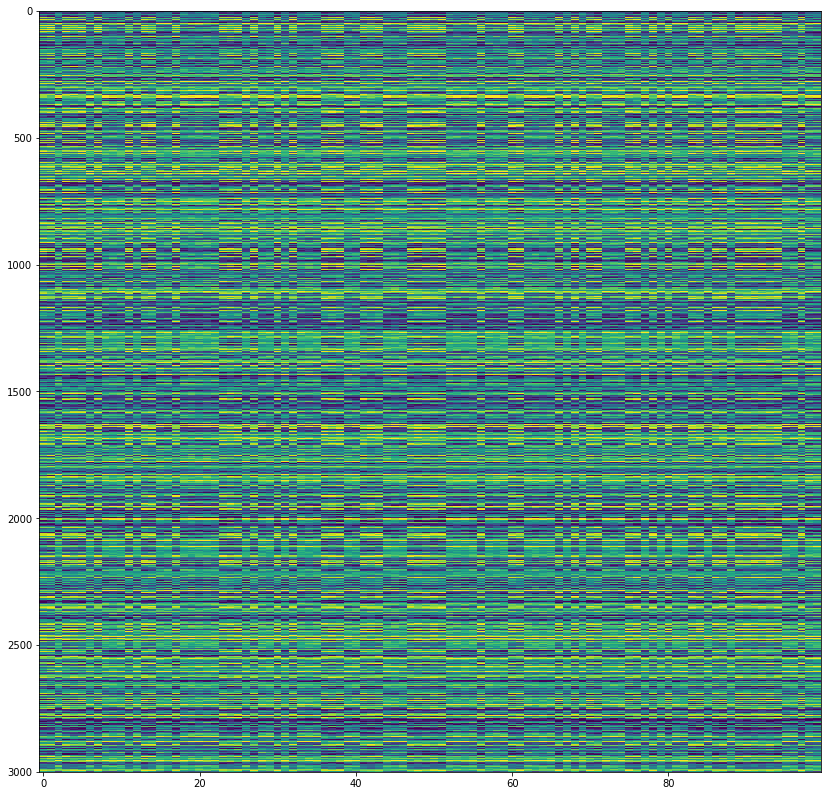

In [28]:
pyvis.qc_2var(X.ravel(),ys.ravel())

pyvis.heatmap(ys)

pyvis.heatmap(X)

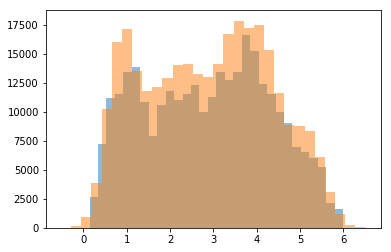

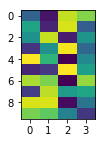

In [29]:
plt.hist(X.ravel(),bins=30,alpha=0.5);

plt.hist(ys.ravel(),bins=30,alpha=0.5);

pyvis.heatmap(post.loc)